# Ali Mohseninejad
# 402210195



# بخش آ

The VQ-VAE uses a discrete latent representation mostly because many important real-world objects are discrete. For example in images we might have categories like "Cat", "Car", etc. and it might not make sense to interpolate between these categories. Discrete representations are also easier to model since each category has a single value whereas if we had a continous latent space then we will need to normalize this density function and learn the dependencies between the different variables which could be very complex.

In [1]:
!pip install umap
!pip install celluloid

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3541 sha256=03a61097c611c9853c0acacba6070c8fc710ddb15cbfa072d46b418ccea9e924
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [2]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import imageio
from PIL import Image, ImageDraw

from celluloid import Camera  # Install celluloid with 'pip install celluloid'

from six.moves import xrange

import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# بخش ب

## Load Data

In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

training_data = datasets.MNIST(root='./data/', train=True, download=True, transform=transform)
print("training data shape",training_data.data.shape)
validation_data = datasets.MNIST(root='./data/', train=False, download=True, transform=transform)
print("validation_data shape",validation_data.data.shape)
batch_size = 256

training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)
validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)


training data shape torch.Size([60000, 28, 28])
validation_data shape torch.Size([10000, 28, 28])


In [11]:
transform = transforms.Compose([transforms.Grayscale(num_output_channels=3),transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))])

training_data = datasets.MNIST(root='./data/', train=True, download=True, transform=transform)
print("training data shape",training_data.data.shape)
validation_data = datasets.MNIST(root='./data/', train=False, download=True, transform=transform)
print("validation_data shape",validation_data.data.shape)
batch_size = 512

training_loader_rgb = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)
validation_loader_rgb = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)


training data shape torch.Size([60000, 28, 28])
validation_data shape torch.Size([10000, 28, 28])


In [12]:
data_variance = torch.var(training_data.data.reshape(-1)/255.0)

In [13]:
def create_gif(tensor_list,fps):

  # Create a figure and axis
  fig, ax = plt.subplots()

  # Use the Camera module from celluloid to create an animation
  camera = Camera(fig)

  # Plot each frame in the animation
  for tensor in tensor_list:
      ax.scatter(tensor[:, 0], tensor[:, 1], c='b', marker='o')
      camera.snap()

  # Create the animation
  animation = camera.animate()

  # Save the animation as a GIF
  animation.save('codebook_animation.gif', writer='imagemagick', fps=fps)
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

# بخش ج، د، ه

In [14]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors.

In [15]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [16]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [17]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return self._residual_stack(x)

In [18]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens,data_channels):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=data_channels,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

## VQ_VAE Model

In [19]:
class Model(nn.Module):
    def __init__(self,data_channels,num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()

        self._encoder = Encoder(data_channels, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens,
                                data_channels)

    def forward(self, x):
        z = self._encoder(x)

        z = self._pre_vq_conv(z)

        loss, quantized, perplexity, encodings = self._vq_vae(z)

        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity,encodings

# بخش و

## Train using 3 × 2D code book
We use the hyperparameters from the author's code:

In [20]:
num_training_updates = 6000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
data_channels = 1
embedding_dim = 2
num_embeddings = 3

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [21]:
model = Model(data_channels,num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)

In [22]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [23]:
model.train()
train_res_recon_error = []
train_res_perplexity = []
code_book = []
for i in xrange(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()
    vq_loss, data_recon, perplexity,_ = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        code_book.append(model._vq_vae._embedding.weight.data.cpu())
        print('%d iterations' % (i+1),'recon_error: %.3f' % np.mean(train_res_recon_error[-100:]),'perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        # embeding weight,input data,output data

100 iterations recon_error: 0.784 perplexity: 1.000
200 iterations recon_error: 0.718 perplexity: 1.000
300 iterations recon_error: 0.713 perplexity: 1.000
400 iterations recon_error: 0.881 perplexity: 1.397
500 iterations recon_error: 0.396 perplexity: 1.856
600 iterations recon_error: 0.262 perplexity: 2.470
700 iterations recon_error: 0.211 perplexity: 2.709
800 iterations recon_error: 0.194 perplexity: 2.733
900 iterations recon_error: 0.183 perplexity: 2.754
1000 iterations recon_error: 0.175 perplexity: 2.767
1100 iterations recon_error: 0.169 perplexity: 2.773
1200 iterations recon_error: 0.165 perplexity: 2.778
1300 iterations recon_error: 0.162 perplexity: 2.780
1400 iterations recon_error: 0.159 perplexity: 2.783
1500 iterations recon_error: 0.157 perplexity: 2.785
1600 iterations recon_error: 0.154 perplexity: 2.787
1700 iterations recon_error: 0.151 perplexity: 2.782
1800 iterations recon_error: 0.150 perplexity: 2.783
1900 iterations recon_error: 0.148 perplexity: 2.788
20

### Plot Loss

In [24]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

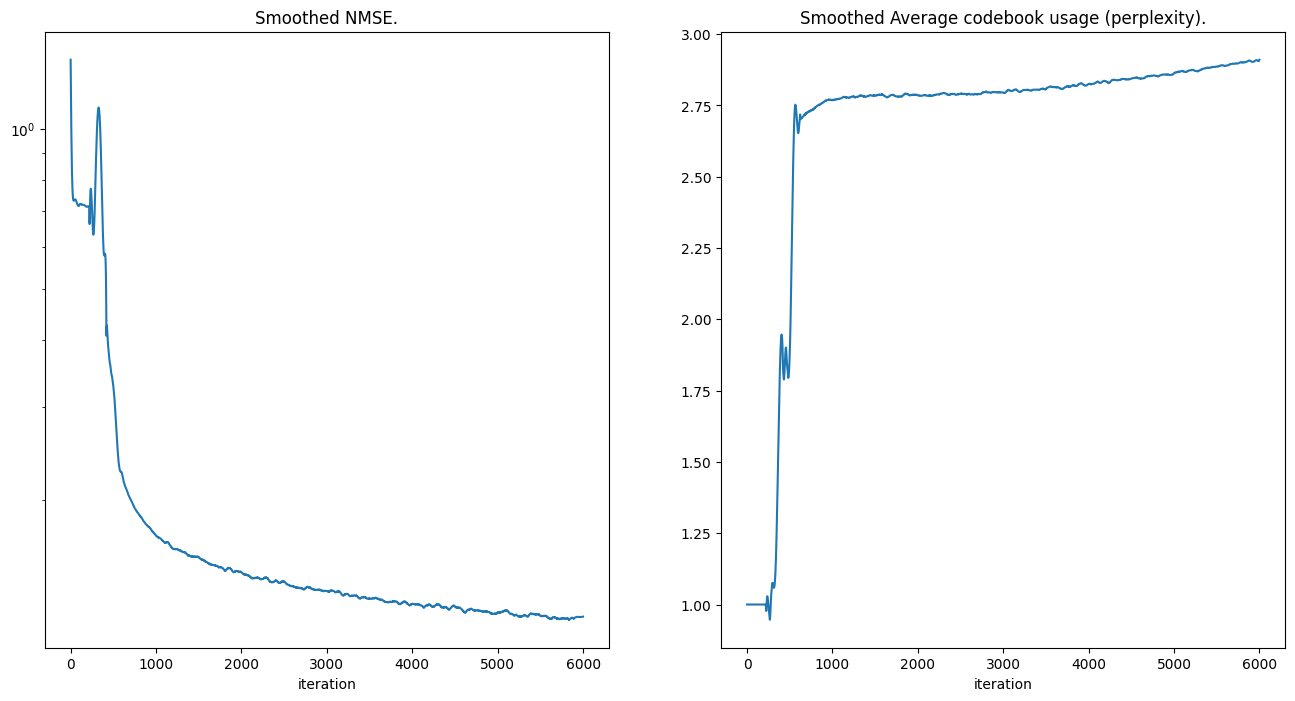

In [25]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

# بخش ز

In [27]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [28]:
(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

### Model output

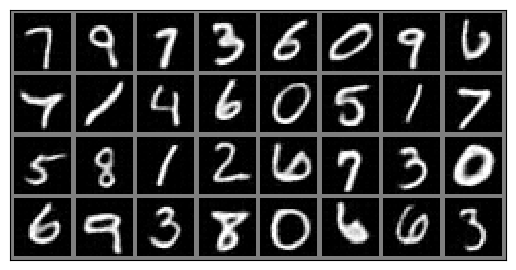

In [29]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

### Model input

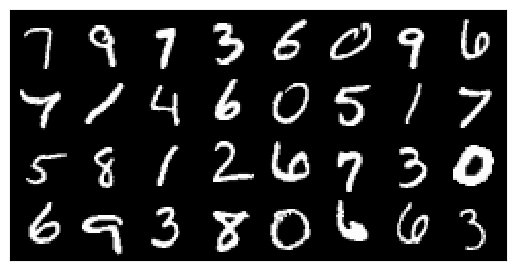

In [30]:
show(make_grid(valid_originals.cpu()+0.5))

### Code book output

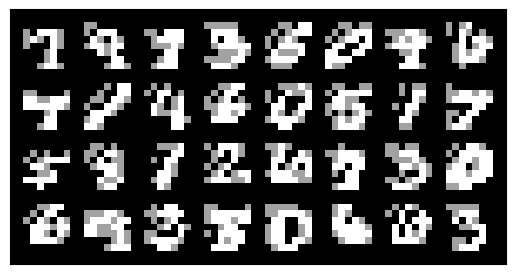

In [31]:
show(make_grid(torch.mean(valid_quantize,dim = 1)[:,None,:,:].detach().cpu()))

# بخش ح

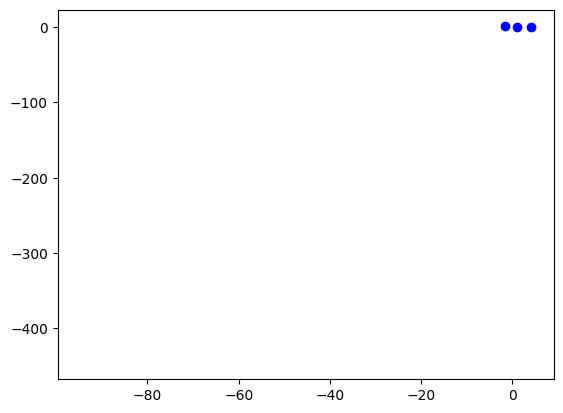

In [ ]:
create_gif(code_book,1)

# بخش ط

### Different number of code books

In [32]:
num_training_updates = 6000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
data_channels = 3
embedding_dim = 2
num_embeddings_list = [10,25,50]

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

train_res_recon_error_diffEmbedding_Num = []
train_res_perplexity_diffEmbedding_Num = []
code_book_diffEmbedding_Num = []
for num_embeddings in num_embeddings_list:
  model = Model(data_channels,num_hiddens, num_residual_layers, num_residual_hiddens,
  num_embeddings, embedding_dim,
  commitment_cost, decay).to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
  model.train()
  train_res_recon_error = []
  train_res_perplexity = []
  code_book = []
  for i in xrange(num_training_updates):
      (data, _) = next(iter(training_loader_rgb))
      data = data.to(device)
      optimizer.zero_grad()
      vq_loss, data_recon, perplexity,_ = model(data)
      recon_error = F.mse_loss(data_recon, data) / data_variance
      loss = recon_error + vq_loss
      loss.backward()

      optimizer.step()

      train_res_recon_error.append(recon_error.item())
      train_res_perplexity.append(perplexity.item())

      if (i+1) % 500 == 0:
          code_book.append(model._vq_vae._embedding.weight.data.cpu())
          print(f'number of codebooks {num_embeddings} , {i+1} iterations'  ,'recon_error: {%.3f}' % np.mean(train_res_recon_error[-500:]),'perplexity: %.3f' % np.mean(train_res_perplexity[-500:]))
          # embeding weight,input data,output data
  train_res_recon_error_diffEmbedding_Num.append(train_res_recon_error)
  train_res_perplexity_diffEmbedding_Num.append(train_res_perplexity)
  code_book_diffEmbedding_Num.append(code_book)

number of codebooks 10 , 500 iterations recon_error: {0.859} perplexity: 1.362
number of codebooks 10 , 1000 iterations recon_error: {0.252} perplexity: 6.725
number of codebooks 10 , 1500 iterations recon_error: {0.125} perplexity: 8.303
number of codebooks 10 , 2000 iterations recon_error: {0.102} perplexity: 8.797
number of codebooks 10 , 3000 iterations recon_error: {0.083} perplexity: 8.947
number of codebooks 10 , 3500 iterations recon_error: {0.079} perplexity: 8.972
number of codebooks 10 , 4000 iterations recon_error: {0.073} perplexity: 8.990
number of codebooks 10 , 4500 iterations recon_error: {0.069} perplexity: 8.982
number of codebooks 10 , 5000 iterations recon_error: {0.066} perplexity: 8.967
number of codebooks 10 , 5500 iterations recon_error: {0.063} perplexity: 8.960
number of codebooks 10 , 6000 iterations recon_error: {0.061} perplexity: 8.942
number of codebooks 25 , 500 iterations recon_error: {1.110} perplexity: 1.567
number of codebooks 25 , 1000 iterations r

In [ ]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [34]:
(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

### Outputs for 50 code books

As we can see in the below image, increasing the number of code books can lead to increased variety of images.

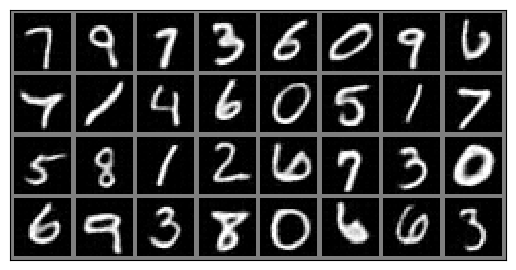

In [35]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

### Original images

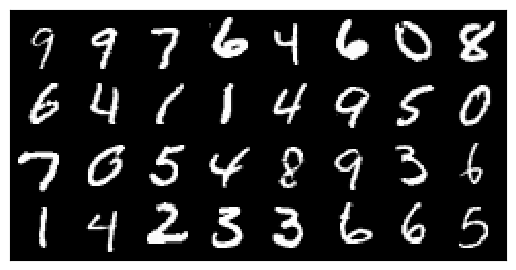

In [36]:
show(make_grid(valid_originals.cpu()+0.5))

### different dim of code books

In [46]:
num_training_updates = 6000

num_hiddens = 128
num_residual_hiddens = 24
num_residual_layers = 2
data_channels = 3
embedding_dim_list = [10,32]
num_embeddings = 3

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

train_res_recon_error_diffEmbedding_Dim = []
train_res_perplexity_diffEmbedding_Dim = []
code_book_diffEmbedding_Dim = []
for embedding_dim in embedding_dim_list:
  model = Model(data_channels,num_hiddens, num_residual_layers, num_residual_hiddens,
  num_embeddings, embedding_dim,
  commitment_cost, decay).to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
  model.train()
  train_res_recon_error = []
  train_res_perplexity = []
  code_book = []
  for i in xrange(num_training_updates):
      (data, _) = next(iter(training_loader_rgb))
      data = data.to(device)
      optimizer.zero_grad()
      vq_loss, data_recon, perplexity,_ = model(data)
      recon_error = F.mse_loss(data_recon, data) / data_variance
      loss = recon_error + vq_loss
      loss.backward()

      optimizer.step()

      train_res_recon_error.append(recon_error.item())
      train_res_perplexity.append(perplexity.item())

      if (i+1) % 500 == 0:
          code_book.append(model._vq_vae._embedding.weight.data.cpu())
          print(f'number of dim of codebooks {embedding_dim} , {i+1} iterations'  ,'recon_error: {%.3f}' % np.mean(train_res_recon_error[-500:]),'perplexity: %.3f' % np.mean(train_res_perplexity[-500:]))
          # embeding weight,input data,output data
  train_res_recon_error_diffEmbedding_Dim.append(train_res_recon_error)
  train_res_perplexity_diffEmbedding_Dim.append(train_res_perplexity)
  code_book_diffEmbedding_Dim.append(code_book)

number of dim of codebooks 10 , 500 iterations recon_error: {0.950} perplexity: 1.089
number of dim of codebooks 10 , 1000 iterations recon_error: {0.441} perplexity: 1.897
number of dim of codebooks 10 , 1500 iterations recon_error: {0.213} perplexity: 2.658
number of dim of codebooks 10 , 2000 iterations recon_error: {0.166} perplexity: 2.900
number of dim of codebooks 10 , 2500 iterations recon_error: {0.153} perplexity: 2.915
number of dim of codebooks 10 , 3000 iterations recon_error: {0.146} perplexity: 2.920
number of dim of codebooks 10 , 3500 iterations recon_error: {0.141} perplexity: 2.921
number of dim of codebooks 10 , 4000 iterations recon_error: {0.138} perplexity: 2.923
number of dim of codebooks 10 , 4500 iterations recon_error: {0.135} perplexity: 2.921
number of dim of codebooks 10 , 5500 iterations recon_error: {0.131} perplexity: 2.917
number of dim of codebooks 10 , 6000 iterations recon_error: {0.129} perplexity: 2.915
number of dim of codebooks 32 , 500 iteratio

In [47]:
model.eval()

(valid_originals, _) = next(iter(validation_loader_rgb))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [48]:
(train_originals, _) = next(iter(training_loader_rgb))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

### Output

The below figure is the output of the model with dimension of 32 for code books (I tried with more than 40 and the result was very bad). You can see that increasing the dimension of the code books, results in some noise in the image. As if the code books hold information about excessive features that are not important.

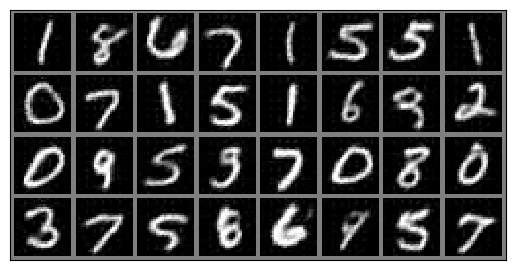

In [49]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

### Input

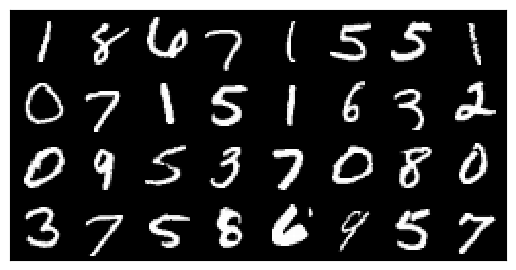

In [50]:
show(make_grid(valid_originals.cpu()+0.5))